## Install Dependencies

In [9]:
!pip install autodistill autodistill-yolov8 roboflow scikit-learn transformers -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Dependencies

First, let's import the dependencies we will use in our project:

In [1]:
from fashionsiglip_model import FashionSigLIP  
from autodistill.detection import CaptionOntology
from autodistill_yolov8 import YOLOv8
import supervision as sv
import transformers
import roboflow
import cv2
import os

HOME = os.getcwd()

## Download Dataset

First, we need a dataset with which to work. Below, paste in a URL to any dataset on [Roboflow Universe](https://universe.roboflow.com). You will need a [free Roboflow account](https://app.roboflow.com) to download a dataset from Universe. Alternatively, you can upload your own dataset into this Colab notebook.

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="rLL83CuCf49rJzyuw4vH")
project = rf.workspace("ahah").project("filter-fashion-images")
version = project.version(2)
dataset = version.download("folder")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Filter-Fashion-Images-2 in folder:: 100%|██████████| 27484/27484 [00:14<00:00, 1860.05it/s]


In [2]:
import torch
print(torch.cuda.is_available())  # Should be True on GPU


True


## Choose a Prompt

To label images with Autodistill, you need to set an Ontology.

An Ontology for classification consists of two parts:

1. A prompt that will be sent to the foundation model (in this example, CLIP), and;
2. A class name to which the prompt maps. This is the class name that will be saved in your dataset. The prompt and class name can be the same.

Below, we define an Ontology for two classes:

1. damaged sign
2. sign

We then run CLIP on an example image in the dataset.

Substitute the prompts and image name as appropriate in the code snippet below.

Feel free to experiment with the prompt until you get the expected result across different images in your dataset.

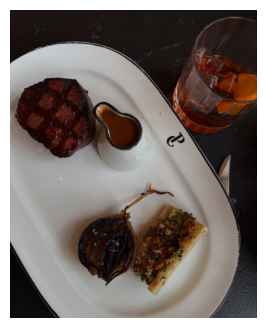

fashion


In [4]:
fashion = [
    "A men's white cotton t-shirt for casual wear",
    "A black long-sleeve dress shirt designed for men",
    "A classic striped polo shirt styled for everyday outfits",
    "A grey crew neck sweatshirt made from soft fleece material",
    "A slim-fit dress shirt suitable for formal occasions",
    "A navy blue hoodie designed for men's streetwear",
    "A sleeveless athletic tank top made for men",
    "A flannel checkered shirt for cool-weather layering",
    "A breathable linen button-down shirt for men",
    "Straight-leg blue denim jeans designed for men",
    "Tailored khaki chino pants suitable for semi-formal events",
    "Black cargo pants for men with multiple utility pockets",
    "Tailored wool trousers for business or formal settings",
    "Athletic jogger pants designed for comfort and performance",
    "Denim shorts for men with a casual summer style",
    "Men’s board shorts designed for beach or swimwear",
    "Pleated dress pants styled for professional attire",
    "A black leather biker jacket made for men's fashion",
    "A classic men's trench coat suitable for rainy weather",
    "A padded winter puffer jacket providing cold-weather insulation",
    "An olive green bomber jacket for casual street style",
    "A grey wool blazer tailored for men's office wear",
    "A lightweight windbreaker jacket for men",
    "A blue denim jacket designed for rugged casual outfits",
    "A utility field jacket featuring military-inspired styling",
    "A compression workout shirt for men's training sessions",
    "Performance training shorts for active men",
    "A men's running jacket made with breathable fabric",
    "A gym stringer tank top with racerback cut",
    "A moisture-wicking t-shirt designed for workouts",
    "A sports hoodie for men's athletic apparel",
    "A complete jogger set for men's activewear",
    "Men’s yoga pants designed for stretch and mobility",
    "Black leather oxford shoes for formal occasions",
    "White fashion sneakers designed for men",
    "Brown suede loafers for a smart-casual look",
    "Men’s cushioned running shoes for athletic use",
    "Casual slip-on shoes for everyday men's outfits",
    "Black dress boots suitable for business attire",
    "Formal derby shoes made with polished leather",
    "Leather sandals for men styled for summer outfits",
    "A classic black leather belt for men",
    "A men's wristwatch with a polished metal band",
    "Aviator-style sunglasses designed for men",
    "A warm knit beanie hat for men's winter fashion",
    "A branded baseball cap with embroidered logo",
    "A functional crossbody sling bag for men",
    "A leather men's briefcase for business essentials",
    "A premium leather wallet for men",
    "A formal silk necktie for professional outfits",
    "A patterned pocket square for men's suit styling",
    "A relaxed-fit cotton t-shirt ideal for men's loungewear",
    "A slim-fit navy suit jacket tailored for men",
    "A wool blend overcoat suited for men's winter fashion",
    "Casual linen pants for men in a breathable design",
    "A ribbed knit sweater designed for men's fall outfits",
    "Tapered black jeans with a modern silhouette for men",
    "A heavyweight flannel overshirt for cold weather",
    "A men’s varsity jacket with stitched logo patches",
    "A traditional Vietnamese áo dài tailored for men",
    "A men’s kurta with fine embroidery details",
    "A men's African print shirt with cultural patterns",
    "A classic black tuxedo with bow tie for formal occasions",
    "A business suit in charcoal gray for corporate settings",
    "A men’s wedding sherwani embroidered for ceremonies",
    "A tailored suit vest for men worn with formal attire"
]

non_fashion = [
    "A scenic view of a mountain landscape during sunset",
    "A quiet forest trail surrounded by tall trees",
    "Ocean waves crashing on a sandy beach",
    "A green houseplant in a ceramic pot on a windowsill",
    "Wild animals grazing in a grassy field",
    "A plate of assorted sushi on a restaurant table",
    "A cup of latte with foam art served in a café",
    "A slice of chocolate cake on a dessert plate",
    "A glass of red wine on a dining table",
    "A smartphone resting on a modern desk setup",
    "A mechanical computer keyboard with LED lights",
    "A person using a virtual reality headset at home",
    "A close-up of a gaming console controller",
    "A modern apartment building under blue sky",
    "A kitchen interior featuring cabinets and countertops",
    "A historic church facade with stained glass windows",
    "A city skyline illuminated at night",
    "A wooden staircase with a minimalist design",
    "A domestic dog sitting on the floor",
    "A cat resting on a windowsill",
    "Various wild and domestic animals in natural settings",
    "A parked car in a suburban neighborhood",
    "A bicycle leaning against a wall",
    "A person playing soccer on a grass field",
    "A child riding a bicycle in a park",
    "A group of people dancing at a party event",
    "A construction worker in safety gear at a job site",
    "A red sports car parked on a street",
    "A wooden bookshelf filled with books",
    "A toolbox containing a hammer and screwdrivers",
    "A ceramic mug placed on a wooden table"
]


ontology = CaptionOntology({
    prompt: "fashion" for prompt in fashion
} | {
    prompt: "non-fashion" for prompt in non_fashion
})

base_model = FashionSigLIP(ontology)

image = r"C:\Users\hanhb\Documents\Trending-Fashion-Analysis\insta_img\3610749264670543112\3.jpg"

pred = base_model.predict(image)

sv.plot_image(cv2.imread(image), size=(4, 4))

classes = base_model.ontology.classes()
print(classes[pred.class_id[0]])

## Label Dataset

Once you have a prompt that works well for your dataset, we can start labeling our dataset.

First, replace the folder name in the code cell below with a link to your `train` dataset. Then, run the code cell.

This will create a folder of labeled images called `dataset` on which we can train our model.

In [ ]:
from fashionsiglip_model import FashionSigLIP  # <-- Make sure this file is in the same directory
from autodistill.detection import CaptionOntology

# Define text prompts for classification
ontology = CaptionOntology({
    "a fashion item": "fashion",
    "a non-fashion object": "non-fashion",
})

# Load model
model = FashionSigLIP(ontology)

# Auto-label the folder (change this if your images are elsewhere)
model.label("C:\Users\hanhb\Documents\Trending-Fashion-Analysis\insta_img")  


In [ ]:
import pandas as pd
import shutil
from pathlib import Path

# Load the labels
df = pd.read_csv("labels.csv")

# Prepare YOLOv8-friendly folder structure
for label in df['label'].unique():
    (Path("dataset/train") / label).mkdir(parents=True, exist_ok=True)

# Copy images to correct folders
for _, row in df.iterrows():
    src = Path(row["image_path"])
    dst = Path("dataset/train") / row["label"] / src.name
    shutil.copy2(src, dst)


In [ ]:
base_model.label(input_folder="./Damaged-Signs-Multi-label-3/train", output_folder="./dataset")

## Train a Classification Model

Now we are ready to train a classification model. For this example, we will train an Ultralytics YOLOv8 classifiaction model. Run the code cell below to train a model using your dataset.

In [6]:
from autodistill_yolov8 import YOLOv8
target_model = YOLOv8("yolov8n-cls.pt")
target_model.train(f"{HOME}/dataset/", epochs=100)

100%|██████████| 5.28M/5.28M [00:00<00:00, 72.5MB/s]
New https://pypi.org/project/ultralytics/8.0.132 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/dataset/, epochs=100, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augm

## Evaluate the Model

How does our model perform? Great question! To understand how our model performs, we can visualize the confusion matrix saved after the YOLOv8 training job completed.

In [11]:
from IPython.display import Image
import random

Image(filename=f'{HOME}/runs/classify/train/confusion_matrix.png', width=600)

random_image = random.choice(os.listdir(f"{HOME}/dataset/valid/damaged sign"))

results = target_model.predict(os.path.join(f"{HOME}/dataset/valid/damaged sign", random_image))

print(results[0].names)
print(results[0].probs)


image 1/1 /content/dataset/valid/damaged sign/IMG_8901_jpg.rf.954ac1fe0615b637515385d4a0afa138.jpg: 224x224 damaged sign 0.96, sign 0.04, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


{0: 'damaged sign', 1: 'sign'}
tensor([0.9636, 0.0364], device='cuda:0')


## Upload Model to Roboflow

Optionally, you can upload your model to Roboflow. To do so:

1. Create a new project in Roboflow
2. Upload your data
3. Create a new dataset version
4. Run the code below

You will need to specify your [project ID and dataset version](https://docs.roboflow.com/rest-api#how-to-find-your-model-id-and-version) below.

In [ ]:
import roboflow

PROJECT_ID = ""
DATASET_VERSION = 1

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace().project(PROJECT_ID)
project.version(DATASET_VERSION).deploy(model_type="yolov8-cls", model_path=f"./runs/classify/train/")

# 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.